## Load data

The dataset is the adult dataset which can be downloaded from the UCI machine learning repository.

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from urllib.request import urlopen
from sklearn.preprocessing import LabelEncoder

name_data = urlopen('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names')
lines = [l.decode("utf-8") for l in name_data if ':' in l.decode("utf-8") and '|' not in l.decode("utf-8")]

features = [l.split(':')[0] for l in lines]
label_name = 'income'

cat_features = [l.split(':')[0] for l in lines if 'continuous' not in l]

train_df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
                       names=features + [label_name])
test_df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test',
                      names=features + [label_name], skiprows=1)

test_df[label_name] = test_df [label_name].str[:-1]

encoder = LabelEncoder()
encoder.fit(train_df[label_name])
train_df[label_name] = encoder.transform(train_df[label_name])
test_df[label_name] = encoder.transform(test_df[label_name])

## Create Dataset

In [3]:
from deepchecks import Dataset

cat_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 
                'race', 'sex', 'native-country']
train_ds = Dataset(train_df, label_name=label_name, cat_features=cat_features)
test_ds = Dataset(test_df, label_name=label_name, cat_features=cat_features)

numeric_features = [feat_name for feat_name in train_ds.features if feat_name not in train_ds.cat_features]


## Classification model

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier

numeric_transformer = SimpleImputer()
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")), ("encoder", OrdinalEncoder())]
)

train_ds.features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, cat_features),
    ]
)

model = Pipeline(steps=[("preprocessing", preprocessor), ("model", RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=0))])
model.fit(train_ds.features_columns, train_ds.label_col);

# Run check

In [5]:
from deepchecks.checks import ModelErrorAnalysis

Model Error Analysis

Find features that best split the data into segments of high and low model error.

Conditions Summary

Status,Condition,More Info
!,The performance of the detected segments must not differ by more than 5.00%,"Change in Accuracy (Default) in features: capital-gain, relationship exceeds threshold."


Additional Outputs

The following graphs show the distribution of error for top features that are most useful for distinguishing
 high error samples from low error samples.

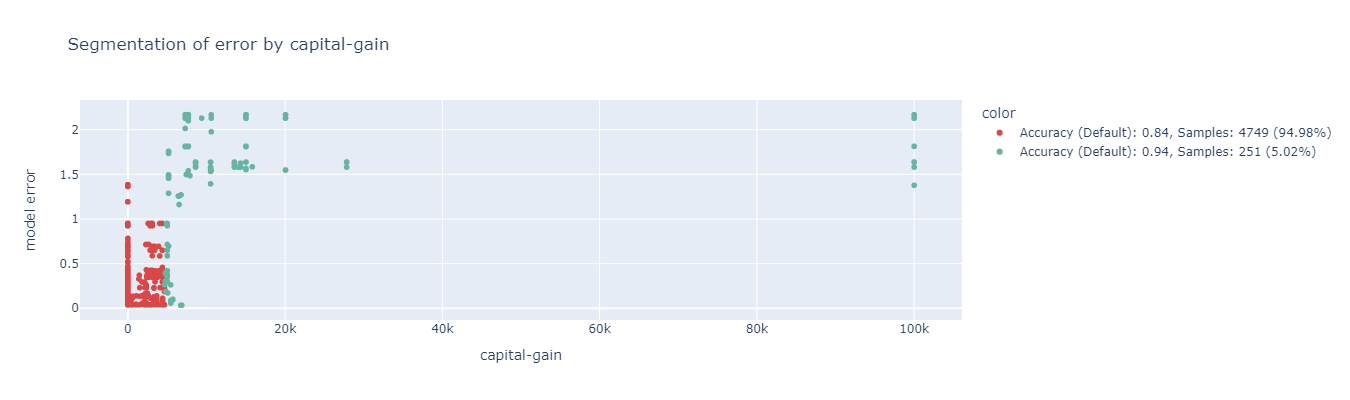

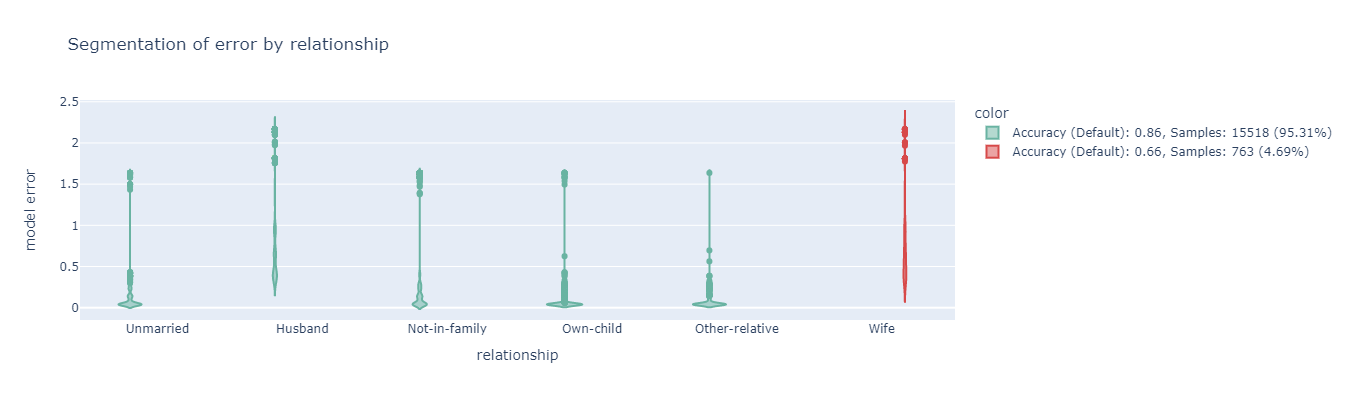

In [8]:
res = ModelErrorAnalysis(min_error_model_score=0.3).add_condition_segments_performance_relative_difference_not_greater_than().run(train_ds, test_ds, model)
res

In [9]:
res.value

{'scorer_name': 'Accuracy (Default)',
 'feature_segments': {'capital-gain': {'segment1': {'score': 0.9442231075697212,
    'n_samples': 251,
    'frac_samples': 0.0502},
   'segment2': {'score': 0.8443882922720573,
    'n_samples': 4749,
    'frac_samples': 0.9498}},
  'relationship': {'segment1': {'score': 0.8595824204150019,
    'n_samples': 15518,
    'frac_samples': 0.9531355567839813},
   'segment2': {'score': 0.6618610747051114,
    'n_samples': 763,
    'frac_samples': 0.046864443216018674}}}}